## Prevendo Alta ou Baixa do Índice IBOVESPA

### Importação de Dados - Bloco 0 ao 1

In [66]:
# Objetivo: Permitir alternar entre teste focado (janela específica) e teste realista (futuro).
MODO_TESTE = 'MANUAL'

# CONFIGURAÇÃO A (Se MODO_TESTE = 'REALISTA')
DATA_CORTE_REALISTA = '2025-09-30'

# CONFIGURAÇÃO B (Se MODO_TESTE = 'MANUAL')
DATA_INICIO_MANUAL = '2025-12-19'
DATA_FIM_MANUAL    = '2026-01-19'
# ==============================================================================

In [67]:
# Bloco 0 - Importação de Bibliotecas
# Importando pandas e numpy
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Yahoo Finance (Mantido para uso futuro, se necessário)
import yfinance as yf

# Importando bibliotecas de visualização
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
sns.set_style("whitegrid")

# Pré-processamento
from sklearn.preprocessing import StandardScaler

# Modelos de classificação
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Validação e Otimização
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV

# Métricas de avaliação
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Biblioteca para salvar modelos
import joblib
import os

In [68]:
# Bloco 1 - Configuração e carga de dados (Via Yfinance)
# Objetivo: Baixar dados, traduzir colunas e garantir tipos (float64/datetime).

print("🔄 Conectando API do Yahoo Finance...")

# 1. Download
ticker = "^BVSP"
inicio = "2016-01-01"
fim = "2026-01-21" 

print(f"Baixando dados de {inicio} até {fim}...")
ibov = yf.download(ticker, start=inicio, end=fim, progress=False)

# 2. Achatamento de cabeçalho
# Se o Yahoo mandar MultiIndex (ex: ('Close', '^BVSP')), pegamos só o primeiro nível.
if isinstance(ibov.columns, pd.MultiIndex):
    ibov.columns = ibov.columns.get_level_values(0)

# 3. Tratamento Inicial (Index -> Coluna)
ibov.reset_index(inplace=True)

# 4. Tradução (ENG -> PT BR)
ibov.rename(columns={
    'Date': 'Data',
    'Open': 'Abertura',
    'High': 'Maxima',
    'Low': 'Minima',
    'Close': 'Último',
    'Volume': 'Volume',
    'Adj Close': 'Fechamento_Ajustado'
}, inplace=True)

# 5. Criação da coluna auxiliar 'Fechamento' (Cópia de estruturação)
ibov['Fechamento'] = ibov['Último']

# 6. Limpeza de colunas extras
if 'Fechamento_Ajustado' in ibov.columns:
    ibov.drop('Fechamento_Ajustado', axis=1, inplace=True)

# 7. Reordenação (Padronização)
colunas_ordem = ['Data', 'Último', 'Abertura', 'Maxima', 'Minima', 'Volume', 'Fechamento']
ibov = ibov[colunas_ordem]

# 8. Tipagem (Garante que Data seja dt64[ns])
ibov['Data'] = pd.to_datetime(ibov['Data'])

# 9. Garante que as colunas numéricas sejam ft64
cols_numericas = ['Último', 'Abertura', 'Maxima', 'Minima', 'Volume', 'Fechamento']
for col in cols_numericas:
    ibov[col] = ibov[col].astype('float64')

# 10. Ordena por data
ibov.sort_values('Data', ascending=True, inplace=True)

# 11. Convertendo e ordenando datas
ibov['Data'] = pd.to_datetime(ibov['Data'], format='%d.%m.%Y')
ibov = ibov.sort_values('Data').reset_index(drop=True)

# 12. Renomeando colunas
print(f"✓ Período: {ibov['Data'].min().date()} até {ibov['Data'].max().date()}")
print(f"✓ Total de dias: {len(ibov)}")

# 13. Print resultado - Validação
print(f"\n✅ Dados carregados, PADRONIZADOS e TIPADOS!")
print(f"   Período: {ibov['Data'].min().date()} até {ibov['Data'].max().date()}")
print(f"   Total de Dias: {len(ibov)}")
print(f"   ")
      
# 14. Validação de Nulos
if ibov.isnull().sum().sum() > 0:
    print(f"\n⚠️ Atenção: Encontrados {ibov.isnull().sum().sum()} valores nulos. Serão tratados a seguir.")
    ibov.dropna(inplace=True)
    

# 15. Explorando os dados
ibov.info()


🔄 Conectando API do Yahoo Finance...
Baixando dados de 2016-01-01 até 2026-01-21...
✓ Período: 2016-01-04 até 2026-01-20
✓ Total de dias: 2496

✅ Dados carregados, PADRONIZADOS e TIPADOS!
   Período: 2016-01-04 até 2026-01-20
   Total de Dias: 2496
   
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Data        2496 non-null   datetime64[ns]
 1   Último      2496 non-null   float64       
 2   Abertura    2496 non-null   float64       
 3   Maxima      2496 non-null   float64       
 4   Minima      2496 non-null   float64       
 5   Volume      2496 non-null   float64       
 6   Fechamento  2496 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 136.6 KB


### EDA - Bloco 2 ao 4

In [69]:
# Bloco 2 - Copy df
# 1. Criação de copy
df = ibov.copy()

# 2. Visualizando df
display(df.head())

# 3. Dados estatísticos de df
display(df.describe().T)

Price,Data,Último,Abertura,Maxima,Minima,Volume,Fechamento
0,2016-01-04,42141.0,43349.0,43349.0,42125.0,2976300.0,42141.0
1,2016-01-05,42419.0,42139.0,42534.0,42137.0,2557200.0,42419.0
2,2016-01-06,41773.0,42410.0,42410.0,41590.0,3935900.0,41773.0
3,2016-01-07,40695.0,41772.0,41772.0,40695.0,4032300.0,40695.0
4,2016-01-08,40612.0,40695.0,41218.0,40463.0,3221600.0,40612.0


,count,mean,min,25%,50%,75%,max,std
Price,,,,,,,,
Data,2496,2021-01-13 07:04:36.923076864,2016-01-04 00:00:00,2018-07-09 00:00:00,2021-01-18 12:00:00,2023-07-20 06:00:00,2026-01-20 00:00:00,NaN
Último,2496.0,101336.85016,37497.0,79732.25,105696.5,120426.5,166277.0,26732.513712
Abertura,2496.0,101289.338942,37501.0,79664.25,105698.5,120373.5,165557.0,26726.588113
Maxima,2496.0,102165.879407,38031.0,80619.0,106739.0,121363.75,166468.0,26796.723305
Minima,2496.0,100462.409054,37046.0,78857.75,104712.5,119703.75,164833.0,26658.78435
Volume,2496.0,7850740.304487,0.0,4013950.0,7946450.0,10816975.0,26029300.0,4145720.06337
Fechamento,2496.0,101336.85016,37497.0,79732.25,105696.5,120426.5,166277.0,26732.513712


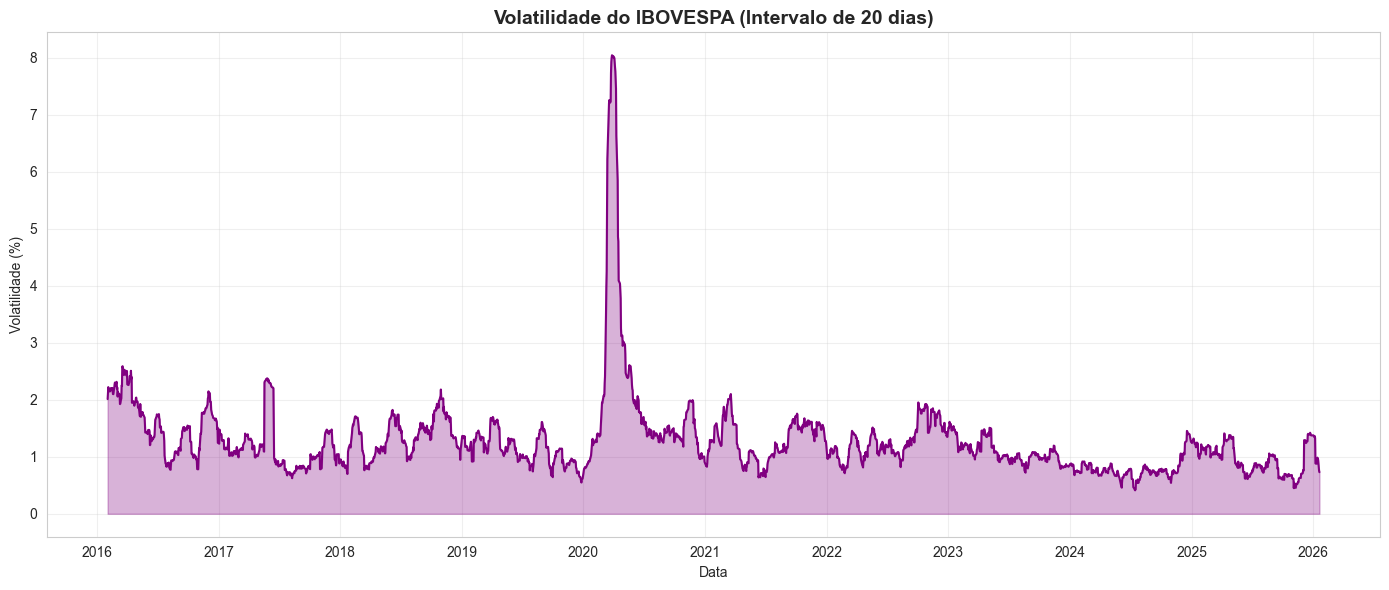

In [70]:
# Bloco 3 - Avaliação de volatilidade do IBOVESPA ao longo do tempo
# 1. Criação de feature auxiliar para visualização (OBS: Não é feature engineering do modelo [Remover no cols_bloq])
df['Vol_IBOV'] = df['Fechamento'].pct_change().rolling(20).std() * 100

plt.figure(figsize=(14, 6))
plt.plot(df['Data'], df['Vol_IBOV'], color='purple', linewidth=1.5)
plt.fill_between(df['Data'], df['Vol_IBOV'], alpha=0.3, color='purple')
plt.title('Volatilidade do IBOVESPA (Intervalo de 20 dias)', fontsize=14, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Volatilidade (%)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

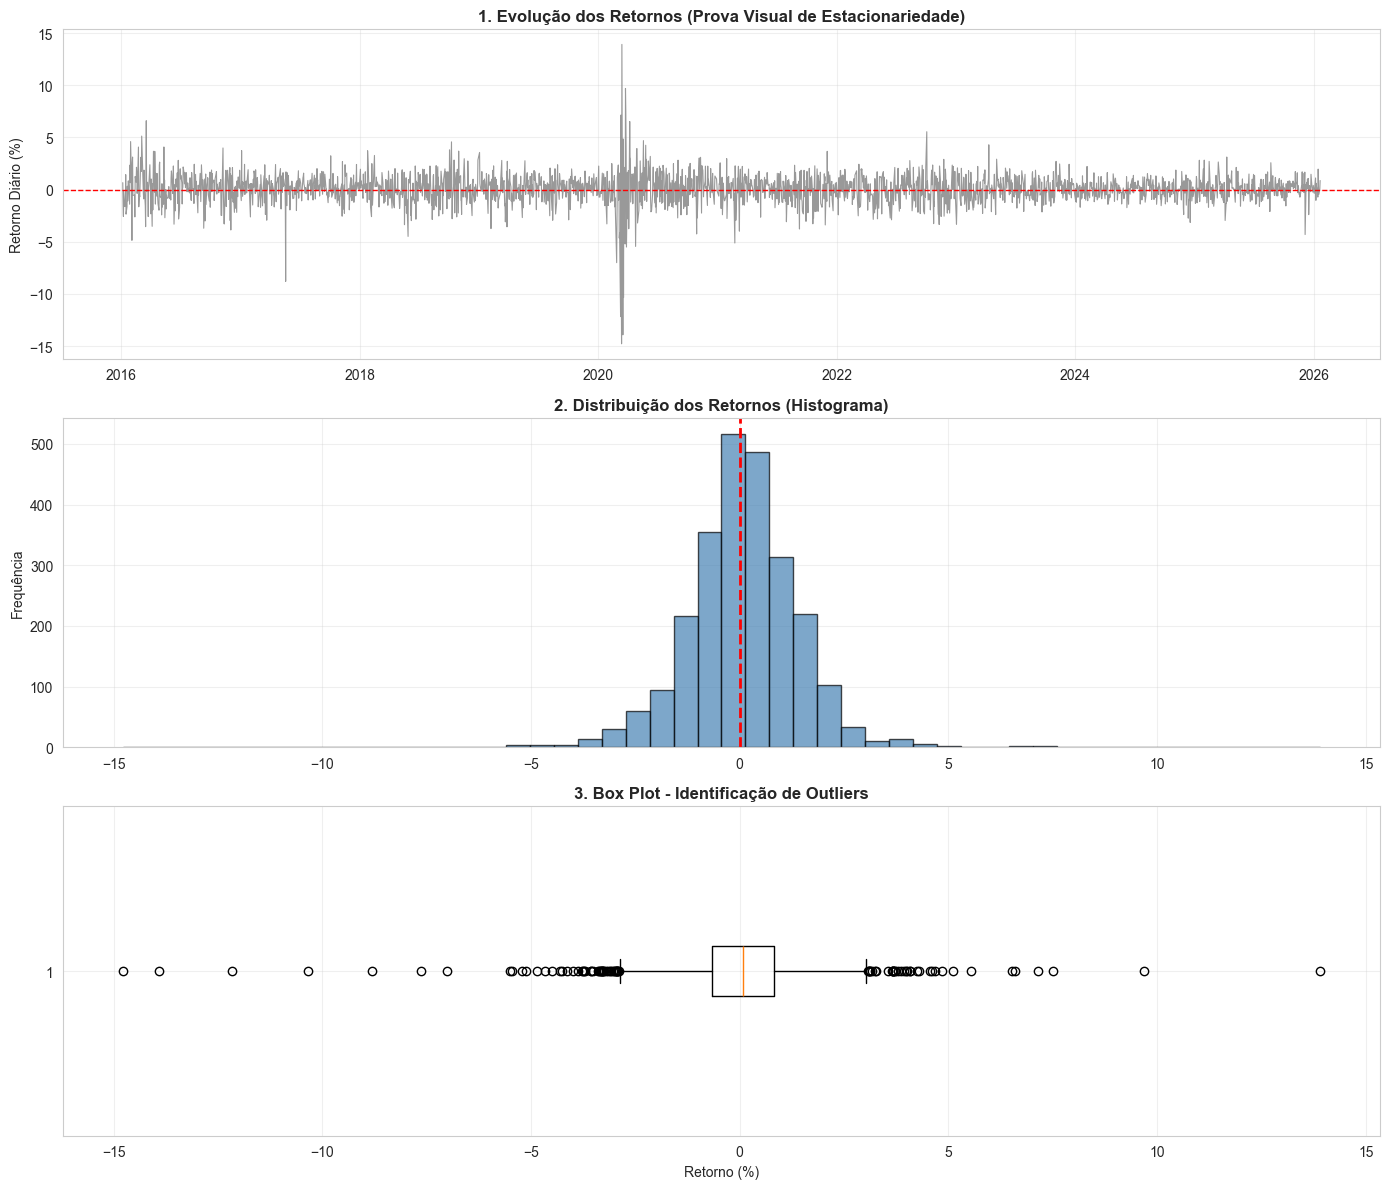

--------------------------------------------------
>> RESULTADO DO TESTE DE ESTACIONARIEDADE (ADF)
--------------------------------------------------
Estatística ADF: -13.2539
p-valor:         8.6653e-25

INTERPRETAÇÃO:
✅ SUCESSO: O p-valor é menor que 0.05.
   Conclusão: A série de Retornos é ESTACIONÁRIA.
   O modelo de Machine Learning funcionará corretamente.
--------------------------------------------------
Estatísticas Descritivas:
Média do Retorno: 0.066%
Volatilidade (Desvio): 1.467%


In [71]:
# BLOCO 4 - Avaliação de Estacionariedade e Normalidade dos Retornos
# Objetivo: Validar estatisticamente se os dados estão prontos para o modelo (check de estacionariedade).

# 1. Criação da Feature de Retorno (Base para o teste)
df['Retorno'] = df['Fechamento'].pct_change() * 100
retornos_limpos = df['Retorno'].dropna()

# 2. Visualização gráfica
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 3. Linha do Tempo (Visualização de Estacionariedade)
# OBS: Se os dados oscilam em torno do zero (linha vermelha) sem tendência de alta/baixa, é estacionário.
axes[0].plot(df['Data'], df['Retorno'], color='gray', alpha=0.8, linewidth=0.8)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('1. Evolução dos Retornos (Prova Visual de Estacionariedade)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Retorno Diário (%)')
axes[0].grid(alpha=0.3)

# 4. Histograma (Distribuição Normal/Anormal)
axes[1].hist(retornos_limpos, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('2. Distribuição dos Retornos (Histograma)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequência')
axes[1].grid(alpha=0.3)

# 5. Box Plot (Identificação de Outliers)
axes[2].boxplot(retornos_limpos, vert=False)
axes[2].set_title('3. Box Plot - Identificação de Outliers', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Retorno (%)')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Teste Estatístico (O P-Valor)
print("-" * 50)
print(">> RESULTADO DO TESTE DE ESTACIONARIEDADE (ADF)")
print("-" * 50)

try:
    result = adfuller(retornos_limpos)
    print(f"Estatística ADF: {result[0]:.4f}")
    print(f"p-valor:         {result[1]:.4e}")

    print("\nINTERPRETAÇÃO:")
    if result[1] <= 0.05:
        print("✅ SUCESSO: O p-valor é menor que 0.05.")
        print("   Conclusão: A série de Retornos é ESTACIONÁRIA.")
        print("   O modelo de Machine Learning funcionará corretamente.")
    else:
        print("⚠️ ALERTA: A série NÃO é estacionária (p > 0.05).")
        print("   O modelo pode ter dificuldades em generalizar.")
except Exception as e:
    print(f"Erro ao rodar o teste ADF. Verifique se a biblioteca 'statsmodels' está instalada. Erro: {e}")

print("-" * 50)
print(f"Estatísticas Descritivas:")
print(f"Média do Retorno: {retornos_limpos.mean():.3f}%")
print(f"Volatilidade (Desvio): {retornos_limpos.std():.3f}%")

### Feature Engineering - Bloco 5 ao 7

In [72]:
#Bloco 5 - Funções auxiliares de métricas financeiras
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(series, fast=12, slow=26):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    return ema_fast - ema_slow

def calculate_stochastic(df, period=14):
    low_min = df['Minima'].rolling(window=period).min()
    high_max = df['Maxima'].rolling(window=period).max()
    return 100 * (df['Fechamento'] - low_min) / (high_max - low_min)

def calculate_atr(df, period=14):
    high_low = df['Maxima'] - df['Minima']
    high_close = abs(df['Maxima'] - df['Fechamento'].shift())
    low_close = abs(df['Minima'] - df['Fechamento'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(window=period).mean()

def adicionar_features_tecnicas(df):

    return df

In [73]:
# Bloco 6 - Feature engineering
# Requisito 0: Tudo que usa Fechamento ou Volume deve ter .shift(1)

def adicionar_features_tecnicas(df):
    # 1. Features de Preço Base (Ontem)
    df['Close_D1'] = df['Fechamento'].shift(1)
    df['Volume_D1'] = df['Volume'].shift(1)
    df['Open_Today'] = df['Abertura'] # Abertura de hoje permitida para Gap Feature

    # 2. Médias Móveis (Calculadas sobre Fechamento passados)
    df['MA_5'] = df['Fechamento'].rolling(window=5).mean().shift(1)
    df['MA_10'] = df['Fechamento'].rolling(window=10).mean().shift(1)
    df['MA_20'] = df['Fechamento'].rolling(window=20).mean().shift(1)
    df['MA_50'] = df['Fechamento'].rolling(window=50).mean().shift(1)

    # 3. Indicadores Técnicos (Somente os que usam fechamento)
    # RSI e MACD usam apenas Fechamento.
    df['RSI'] = calculate_rsi(df['Fechamento'], 14).shift(1)
    df['MACD'] = calculate_macd(df['Fechamento']).shift(1)

    # 4. Criação de df para STOCH & ATR (Com dados de hoje/futuro)
    # Calculamos o indicador como se o dia já tivesse acabado
    df['Stoch_Raw'] = calculate_stochastic(df)
    df['ATR_Raw']   = calculate_atr(df)

    # 4.1. Limpeza ("Estocástico de Hoje" -> "Estocástico de Ontem" com shift(1))
    df['Stoch_D1'] = df['Stoch_Raw'].shift(1)
    df['ATR_D1']   = df['ATR_Raw'].shift(1)

    # 4.2. A REMOÇÃO DAS PROVAS
    # Jogamos fora as colunas Raw que contêm o vazamento
    df.drop(columns=['Stoch_Raw', 'ATR_Raw'], inplace=True)

    # 5. Volatilidade e Bollinger Bands (Baseado em Desvio Padrão do Fechamento - OK)
    df['Volatility_10'] = df['Fechamento'].rolling(window=10).std().shift(1)
    df['Volatility_20'] = df['Fechamento'].rolling(window=20).std().shift(1)

    # 6. Bandas usam médias e volatilidade já calculadas (seguro)
    df['BB_upper'] = df['MA_20'] + (2 * df['Volatility_20'])
    df['BB_lower'] = df['MA_20'] - (2 * df['Volatility_20'])

    # 7. Posição do preço em relação às bandas (normalizada)
    df['BB_position'] = (df['Close_D1'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])

    # 8. Retornos (Baseados em D-1)
    df['Return_1d'] = df['Fechamento'].pct_change(1).shift(1)
    df['Return_3d'] = df['Fechamento'].pct_change(3).shift(1)
    df['Return_5d'] = df['Fechamento'].pct_change(5).shift(1)

    # 9. Momentum e ROC (Baseados em D-1)
    df['Momentum_5'] = (df['Fechamento'] - df['Fechamento'].shift(5)).shift(1)
    df['ROC_5'] = (((df['Fechamento'] - df['Fechamento'].shift(5)) / df['Fechamento'].shift(5)) * 100).shift(1)

    # 10. Cruzamento de Médias (Sinais simples)
    df['MA_Cross_5_20'] = (df['MA_5'] > df['MA_20']).astype(int)
    df['MA_Cross_10_50'] = (df['MA_10'] > df['MA_50']).astype(int)

    # 11. Distância das Médias (Mean Reversion)
    df['Dist_MA5'] = ((df['Close_D1'] - df['MA_5']) / df['MA_5']) * 100
    df['Dist_MA20'] = ((df['Close_D1'] - df['MA_20']) / df['MA_20']) * 100

    # 12. Range e Gap
    # Calcula: (Máxima de ONTEM - Mínima de ONTEM) / Fechamento de ONTEM
    df['Range_Pct'] = ((df['Maxima'].shift(1) - df['Minima'].shift(1)) / df['Fechamento'].shift(1)) * 100
    df.dropna(subset=['Range_Pct'], inplace=True) # Limpa os NaNs gerados pelo shift no começo do DF

    # 13. GAP Feature  (Usa Open de Hoje e Close de Ontem)
    df['Gap'] = ((df['Open_Today'] - df['Close_D1']) / df['Close_D1']) * 100

    # 14. Volume (Baseado em Ontem)
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean().shift(1)
    df['Volume_Ratio'] = df['Volume_D1'] / df['Volume_MA5']

    # 15. Temporal
    df['DayOfWeek'] = df['Data'].dt.dayofweek
    df['Month'] = df['Data'].dt.month
    df['Year'] = df['Data'].dt.year
    df['Quarter'] = df['Data'].dt.quarter

    # 16. Removemos linhas iniciais que ficaram com NaN devido ao shift
    df = df.dropna().reset_index(drop=True)

    return df

# 17. Aplicação da função
df = adicionar_features_tecnicas(df)

# 18. Verificação
print("✓ Features Blindadas criadas com sucesso.")
print(f"✓ Linhas restantes: {len(df)}")
print("✓ Colunas atuais:", df.columns.tolist())
df.head()

print("✓ Features IBOVESPA recriadas.")

# 19. Visualizando df
df.head()

✓ Features Blindadas criadas com sucesso.
✓ Linhas restantes: 2446
✓ Colunas atuais: ['Data', 'Último', 'Abertura', 'Maxima', 'Minima', 'Volume', 'Fechamento', 'Vol_IBOV', 'Retorno', 'Close_D1', 'Volume_D1', 'Open_Today', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'RSI', 'MACD', 'Stoch_D1', 'ATR_D1', 'Volatility_10', 'Volatility_20', 'BB_upper', 'BB_lower', 'BB_position', 'Return_1d', 'Return_3d', 'Return_5d', 'Momentum_5', 'ROC_5', 'MA_Cross_5_20', 'MA_Cross_10_50', 'Dist_MA5', 'Dist_MA20', 'Range_Pct', 'Gap', 'Volume_MA5', 'Volume_Ratio', 'DayOfWeek', 'Month', 'Year', 'Quarter']
✓ Features IBOVESPA recriadas.


Price,Data,Último,Abertura,Maxima,Minima,Volume,Fechamento,Vol_IBOV,Retorno,Close_D1,Volume_D1,Open_Today,MA_5,MA_10,MA_20,MA_50,RSI,MACD,Stoch_D1,ATR_D1,Volatility_10,Volatility_20,BB_upper,BB_lower,BB_position,Return_1d,Return_3d,Return_5d,Momentum_5,ROC_5,MA_Cross_5_20,MA_Cross_10_50,Dist_MA5,Dist_MA20,Range_Pct,Gap,Volume_MA5,Volume_Ratio,DayOfWeek,Month,Year,Quarter
0,2016-03-17,50914.0,47770.0,51268.0,47770.0,7245100.0,50914.0,2.583058,6.597157,47763.0,5111000.0,47770.0,48594.0,48626.1,45620.65,42063.40,73.230526,2053.366804,72.534004,1538.357143,933.138486,3249.880942,52120.411883,39120.888117,0.664802,0.013431,-0.037793,-0.018535,-902.0,-1.853488,1,1,-1.710088,4.696009,2.707116,0.014656,5776740.0,0.884755,3,3,2016,1
1,2016-03-18,50815.0,50915.0,51308.0,50202.0,5448400.0,50815.0,2.590713,-0.194446,50914.0,7245100.0,50915.0,48862.6,48998.2,46092.45,42238.86,80.065802,2184.285272,96.338815,1711.714286,1034.561292,3301.346591,52695.143182,39489.756818,0.865120,0.065972,0.041889,0.027092,1343.0,2.709245,1,1,4.198303,10.460607,6.870409,0.001964,5732320.0,1.263904,4,3,2016,1
2,2016-03-21,51172.0,50816.0,51370.0,50765.0,3708500.0,51172.0,2.491002,0.702548,50815.0,5448400.0,50816.0,49097.8,49171.2,46556.05,42406.78,77.852629,2254.067145,94.208857,1686.428571,1184.473235,3279.805682,53115.661364,39996.438636,0.824634,-0.001944,0.078188,0.023691,1176.0,2.369105,1,1,3.497509,9.148005,2.176523,0.001968,5621560.0,0.969197,0,3,2016,1
3,2016-03-22,51010.0,51170.0,51215.0,50812.0,3896600.0,51010.0,2.437039,-0.316579,51172.0,3708500.0,51170.0,49558.8,49363.8,46952.90,42594.76,76.251117,2311.530810,97.370169,1630.571429,1343.852241,3336.506239,53625.912478,40279.887522,0.816132,0.007025,0.071373,0.047169,2305.0,4.716885,1,1,3.255123,8.985813,1.182287,-0.003908,5403040.0,0.686373,1,3,2016,1
4,2016-03-23,49690.0,51005.0,51005.0,49491.0,3638700.0,49690.0,2.526807,-2.587728,51010.0,3896600.0,51005.0,50334.8,49554.6,47377.35,42801.06,73.859115,2317.286892,94.435858,1577.785714,1434.915344,3282.556534,53942.463068,40812.236932,0.776663,-0.003166,0.001886,0.082325,3880.0,8.232548,1,1,1.341418,7.667482,0.790041,-0.009802,5081920.0,0.766757,2,3,2016,1


In [74]:
# Bloco 7 - Limpeza de dados
# Objetivo: Remover NaNs gerados pelos shifts e cálculos de indicadores.
# OBS: NÃO usamos 'bfill' para evitar olhar dados do futuro nas primeiras linhas.

print("\n🔧 Limpando dados...")
antes = len(df)

# 1.Substituir infinitos por NaN (gerados por divisões por zero, ex: pct_change em dias parados)
df = df.replace([np.inf, -np.inf], np.nan)

# 2.Preencher NaNs apenas com Forward Fill (dados passados) se houver buracos no meio
# Mas para o início da série (gerado pelos shifts), dropamos.
df = df.fillna(method='ffill')

# 3.Remover linhas com NaN restantes (crucial para eliminar o início "vazio" da série)
df = df.dropna()
depois = len(df)

print(f"✓ Dataset limpo: {depois} linhas")
print(f"✓ Linhas removidas (janela de aquecimento dos indicadores): {antes - depois}")


🔧 Limpando dados...
✓ Dataset limpo: 2446 linhas
✓ Linhas removidas (janela de aquecimento dos indicadores): 0


### Preparação dos Dados - 8 ao 9

✓ Features limpas: 33
✓ Colunas removidas: ['Data', 'Target', 'Fechamento', 'Abertura', 'Maxima', 'Minima', 'Volume', 'Fechamento_Ajustado', 'Último', 'Vol.', 'Maxima', 'Minima', 'Retorno', 'Vol_IBOV']


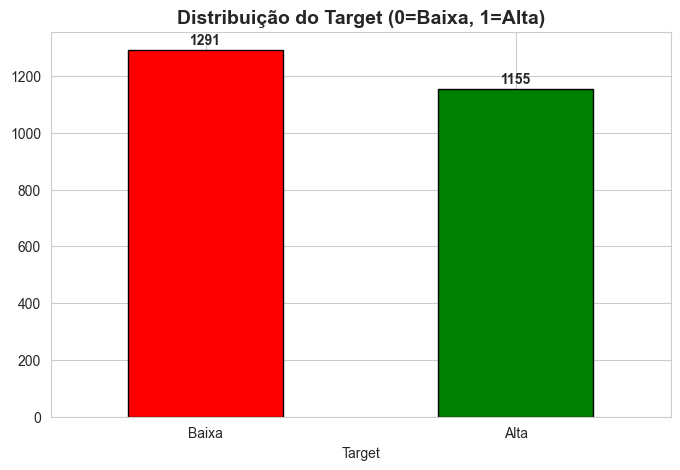

In [75]:
# Bloco 8 - Definição de Target e limpeza de leakage

# 1. Lógica: O Fechamento de HOJE foi maior que o de ONTEM?
df['Target'] = (df['Fechamento'] > df['Fechamento'].shift(1)).astype(int)

# 2. Removemos linhas com NaN gerados pelo shift
df = df.dropna()

# 3. Removendo todas as colunas que contém dados do futuro/presente
cols_proibidas = [
    'Data','Target','Fechamento', 'Abertura', 'Maxima', 'Minima', 'Volume', 'Fechamento_Ajustado', # Nomes Padrão
    'Último', 'Vol.',         # Nomes Yahoo
    'Maxima', 'Minima', 'Retorno', 'Vol_IBOV'    # Nomes Legados
]

# 4. Definição das features (X) e dependente (y)
# OBS: Drop seguro (ignora erros se a coluna não existir)
X = df.drop(cols_proibidas, axis=1, errors='ignore')
y = df['Target']
datas = df['Data']

print(f"✓ Features limpas: {len(X.columns)}")
print(f"✓ Colunas removidas: {cols_proibidas}")

# 5. Visualização da distribuição
plt.figure(figsize=(8, 5))
df['Target'].value_counts().plot(kind='bar', color=['red', 'green'], edgecolor='black')
plt.title('Distribuição do Target (0=Baixa, 1=Alta)', fontsize=14, fontweight='bold')
plt.xticks([0, 1], ['Baixa', 'Alta'], rotation=0)
for i, v in enumerate(df['Target'].value_counts()):
    plt.text(i, v + 20, str(v), ha='center', fontweight='bold')
plt.show()

In [76]:
# BLOCO 9 - Divisão treino/teste (Híbrido: MANUAL ou REALISTA)
# Objetivo: Permitir alternar entre teste focado (janela específica) e teste realista (futuro).
# ==============================================================================
# Opções: 'REALISTA' (Treina no passado, testa no futuro) ou 'MANUAL' (Treina até D-1 da data inicio escolhida, testa d0 para frente da data inicio escolhida)


print(f"⏳ Configurando Divisão: Modo {MODO_TESTE}...")

# 1. Definição das Features
# OBS: Mantemos a proteção contra vazamento independente do modo.

cols_proibidas = [
    'Data','Target','Fechamento', 'Abertura', 'Maxima', 'Minima', 'Volume', 'Fechamento_Ajustado', # Nomes Padrão
    'Último', 'Vol.',         # Nomes Yahoo
    'Maxima', 'Minima', 'Retorno', 'Vol_IBOV'    # Nomes Legados
]

features = [col for col in df.columns if col not in cols_proibidas]

# 2. Lógica de Seleção das Máscaras
if MODO_TESTE == 'REALISTA':
    # Lógica Cronológica Padrão
    mask_train = (df['Data'] < DATA_CORTE_REALISTA)
    mask_test = (df['Data'] >= DATA_CORTE_REALISTA)
    print(f"   Corte Temporal: {DATA_CORTE_REALISTA}")

elif MODO_TESTE == 'MANUAL':
    # Lógica da Janela Específica (O resto vira treino)
    mask_test = (df['Data'] >= DATA_INICIO_MANUAL) & (df['Data'] <= DATA_FIM_MANUAL)
    mask_train = ~mask_test # Todo o resto é treino
    print(f"   Janela Manual: {DATA_INICIO_MANUAL} até {DATA_FIM_MANUAL}")

# 3. Aplicação do Split
X_train_raw = df.loc[mask_train, features]
y_train = df.loc[mask_train, 'Target']

X_test_raw = df.loc[mask_test, features]
y_test = df.loc[mask_test, 'Target']

# 3.1 Guardamos datas e preços para gráficos
datas_test = df.loc[mask_test, 'Data']
precos_test = df.loc[mask_test, 'Fechamento']

# 4. Normalização (Escalonamento)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# 5. Validação
print("\n📊 Resumo da Divisão:")
print(f"   Treino: {len(y_train)} dias")
print(f"   Teste:  {len(y_test)} dias ({df.loc[mask_test, 'Data'].min().date()} a {df.loc[mask_test, 'Data'].max().date()})")

if len(y_test) < 10:
    print("⚠️ ALERTA CRÍTICO: Janela de teste muito pequena ou vazia! Verifique as datas.")
else:
    print("✅ Divisão Concluída.")

⏳ Configurando Divisão: Modo MANUAL...
   Janela Manual: 2025-12-19 até 2026-01-19

📊 Resumo da Divisão:
   Treino: 2428 dias
   Teste:  18 dias (2025-12-19 a 2026-01-19)
✅ Divisão Concluída.


### Cross Validation - Bloco 10 ao 14

In [77]:
# Bloco 10 - Renomeando X para selected_features por segurança

# 1. Bypass: As "features selecionadas" são TODAS as features - ###### No bloco 20 é feito a divisão entre selected_features e x COLUMNS, ele só usa selectd se estiver usando rfec... Validar isto.
selected_features = X.columns.tolist()

X_train_scaled_sel = X_train_scaled
X_test_scaled_sel = X_test_scaled

print(f"\n✓ Features mantidas para o modelo: {len(selected_features)}")


✓ Features mantidas para o modelo: 33


In [78]:
# Bloco 11 - Definição dos modelos com hiperparâmetros otimizados
modelos_cv = {
    'Logistic Regression': LogisticRegression(
        C=0.01,
        max_iter=1000,
        random_state=42
    ),

    'Random Forest': RandomForestClassifier(
        n_estimators=50,
        max_depth=4,
        min_samples_split=50,
        min_samples_leaf=20,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),

    'XGBoost': XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.01,
        subsample=0.7,
        colsample_bytree=0.5,
        reg_alpha=1.0,
        reg_lambda=2.0,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
}

In [79]:
# Bloco 12 - Treinamento e validação cruzada (Cross-Validation)
# Objetivo: Testar vários modelos nos dados limpos e cronológicos.

print("🚀 Iniciando Treinamento com TimeSeriesSplit...")

# 1. Modelos para testar
modelos = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42, eval_metric='logloss'),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

# 2. Configuração da Validação Cruzada Temporal (Respeita o tempo)
# OBS: 5 divisões: Treina em Jan/Fev -> Testa Março; Treina Jan/Fev/Mar -> Testa Abril...
tscv = TimeSeriesSplit(n_splits=5)

resultados = {}

for nome, modelo in modelos.items():
    cv_scores = cross_val_score(modelo, X_train_scaled_sel, y_train, cv=tscv, scoring='accuracy')
    print(f"{nome}: Média {cv_scores.mean():.2%} (+/- {cv_scores.std():.2%})")

    # Treina no conjunto total de treino para avaliação final
    modelo.fit(X_train_scaled_sel, y_train)
    acc_train = modelo.score(X_train_scaled_sel, y_train)

    # Se X_test_scaled_sel não existir (caso não tenha seleção), usa o original
    X_teste_final = X_test_scaled_sel if 'X_test_scaled_sel' in locals() else X_test_scaled
    acc_test = modelo.score(X_teste_final, y_test)

    resultados[nome] = {'Modelo': modelo, 'Train': acc_train, 'Test': acc_test}
    print(f"   ✓ {nome:20s} | Treino: {acc_train:.1%} | Teste (Futuro): {acc_test:.1%}")

# 3. Seleção do Melhor Modelo (baseado no Teste)
melhor_nome = max(resultados, key=lambda k: resultados[k]['Test'])
melhor_modelo = resultados[melhor_nome]['Modelo']
melhor_acc = resultados[melhor_nome]['Test'] * 100

print(f"\n🏆 MELHOR MODELO: {melhor_nome} com {melhor_acc:.2f}% de acurácia no teste.")

# Salva features finais para os gráficos
features_finais = selected_features if 'selected_features' in locals() else features

🚀 Iniciando Treinamento com TimeSeriesSplit...
Logistic Regression: Média 52.77% (+/- 1.50%)
   ✓ Logistic Regression  | Treino: 56.6% | Teste (Futuro): 50.0%
Random Forest: Média 57.67% (+/- 2.81%)
   ✓ Random Forest        | Treino: 71.0% | Teste (Futuro): 61.1%
XGBoost: Média 58.12% (+/- 4.24%)
   ✓ XGBoost              | Treino: 69.2% | Teste (Futuro): 66.7%
SVM: Média 51.58% (+/- 1.70%)
   ✓ SVM                  | Treino: 63.4% | Teste (Futuro): 61.1%

🏆 MELHOR MODELO: XGBoost com 66.67% de acurácia no teste.


In [80]:
# Bloco 13 - Avaliação detalhada (Baseline com Cross-Validation)
# Objetivo: Validar a estabilidade dos modelos (CV) e verificar overfitting.

# 1. Configuração da Validação Cruzada (Respeita a ordem temporal)
tscv = TimeSeriesSplit(n_splits=5)

# 2. Reinicializa resultados para garantir dados frescos
resultados = {}

# 3. Define qual X de teste usar (Segurança: usa o selecionado se existir, senão usa o total)
X_teste_final = X_test_scaled_sel if 'X_test_scaled_sel' in locals() else X_test_scaled

print("Iniciando Cross-Validation Detalhado...")

# 4. Usa o dicionário 'modelos' definido no Bloco 12
for nome, modelo in modelos.items():
    print(f"\n>> {nome}...")

    # 4.1. Validação Cruzada (CV) - Avalia a estabilidade no TREINO
    # Nota: O CV divide o treino em pedaços temporais
    cv_scores = cross_val_score(
        modelo,
        X_train_scaled_sel, # Usa o X de treino selecionado
        y_train,
        cv=tscv,
        scoring='accuracy',
        n_jobs=-1
    )

    print(f"   CV Scores: {[f'{s:.3f}' for s in cv_scores]}")
    print(f"   Média CV: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

    # 4.2. Treinamento Final (Fit) no Treino Completo
    modelo.fit(X_train_scaled_sel, y_train)

    # 4.3. Avaliação Final
    acc_train = modelo.score(X_train_scaled_sel, y_train)
    acc_test = modelo.score(X_teste_final, y_test)

    # 4.4. Salvar resultados no padrão para os gráficos
    resultados[nome] = {
        'Modelo': modelo,        # Guardamos o objeto treinado
        'cv_mean': cv_scores.mean(),
        'acc_train': acc_train,
        'acc_test': acc_test
    }

    # 4.5. Verificar Overfitting (Diferença entre Treino e Teste)
    diff = acc_train - acc_test
    status = "✓ Estável" if diff < 0.15 else "⚠️ Overfitting"

    print(f"   Treino: {acc_train*100:.2f}% | Teste: {acc_test*100:.2f}% | Diff: {diff*100:.1f}% {status}")

# 5. Atualiza as variáveis do Melhor Modelo com base nessa rodada mais detalhada
melhor_nome = max(resultados, key=lambda k: resultados[k]['acc_test'])
melhor_modelo = resultados[melhor_nome]['Modelo']
melhor_acc = resultados[melhor_nome]['acc_test'] * 100

print("-" * 50)
print(f"Melhor resultado confirmado!: {melhor_nome} ({melhor_acc:.2f}%)")

Iniciando Cross-Validation Detalhado...

>> Logistic Regression...
   CV Scores: ['0.500', '0.532', '0.535', '0.545', '0.527']
   Média CV: 0.528 (±0.015)
   Treino: 56.59% | Teste: 50.00% | Diff: 6.6% ✓ Estável

>> Random Forest...
   CV Scores: ['0.537', '0.569', '0.569', '0.624', '0.584']
   Média CV: 0.577 (±0.028)
   Treino: 70.96% | Teste: 61.11% | Diff: 9.9% ✓ Estável

>> XGBoost...
   CV Scores: ['0.530', '0.540', '0.594', '0.646', '0.597']
   Média CV: 0.581 (±0.042)
   Treino: 69.19% | Teste: 66.67% | Diff: 2.5% ✓ Estável

>> SVM...
   CV Scores: ['0.498', '0.517', '0.498', '0.542', '0.525']
   Média CV: 0.516 (±0.017)
   Treino: 63.43% | Teste: 61.11% | Diff: 2.3% ✓ Estável
--------------------------------------------------
Melhor resultado confirmado!: XGBoost (66.67%)


In [81]:
# Bloco 14 - Auditoria de Vazamento de Dados
print(" Auditoria de features (Correlação com Target)...")

# 1. Calcula a correlação de todas as features com o Target
correlations = X_train_scaled_sel.copy() if isinstance(X_train_scaled_sel, pd.DataFrame) else pd.DataFrame(X_train_scaled_sel, columns=selected_features)
correlations['TARGET_TEMP'] = y_train.values
corr_matrix = correlations.corr()['TARGET_TEMP'].abs().sort_values(ascending=False)

print("\n>> TOP 10 Features mais suspeitas (Correlação próxima de 1.0 = Vazamento):")
print(corr_matrix.head(10))

# 2. Se houver alguma correlação > 0.90 (exceto o próprio Target), temos um vazamento.
if corr_matrix.iloc[1] > 0.90:
    print(f"\n>> NOK! A feature '{corr_matrix.index[1]}' está vazando a resposta!")
else:
    print("\n>> OK! Nenhuma feature óbvia encontrada (Features OK).")

 Auditoria de features (Correlação com Target)...

>> TOP 10 Features mais suspeitas (Correlação próxima de 1.0 = Vazamento):
TARGET_TEMP    1.000000
Gap            0.081579
Return_1d      0.056953
Dist_MA5       0.039863
BB_lower       0.037569
MA_20          0.036364
Close_D1       0.035786
Open_Today     0.035465
MA_50          0.034931
BB_upper       0.034757
Name: TARGET_TEMP, dtype: float64

>> OK! Nenhuma feature óbvia encontrada (Features OK).


### Otimização GRID SEARCH (XGBoost only) - Bloco 15

In [82]:
# Bloco 15 - Otimização de hiperparametros (XGBoost)
# OBS: Validação e foco no XGBoost conforme sugestão do professor.

# 1. Parâmetros específicos para tunar o XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],         # Quantidade de árvores
    'max_depth': [3, 5, 7],                 # Profundidade máxima (evita overfitting)
    'learning_rate': [0.01, 0.05, 0.1],     # Taxa de aprendizado
    'subsample': [0.8, 1.0],                # Amostragem de linhas
    'colsample_bytree': [0.8, 1.0]          # Amostragem de colunas
}

# 2. Instancia o modelo base
xgb_grid = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

print("\n🔍 Otimizando XGBoost (Isso pode demorar um pouco)...")

# 3. Configura o Grid Search
grid_search = GridSearchCV(
    estimator=xgb_grid,
    param_grid=param_grid_xgb,
    cv=tscv,              # Usa a validação temporal definida antes
    scoring='accuracy',
    n_jobs=-1,
    verbose=1             # Verbose 1 mostra o progresso
)

# 4. Treina
grid_search.fit(X_train_scaled_sel, y_train)

# 5. Resultados
print(f"\n✓ Melhores parâmetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

best_model = grid_search.best_estimator_
acc_train_best = best_model.score(X_train_scaled_sel, y_train)
acc_test_best = best_model.score(X_test_scaled_sel, y_test)

print(f"\n📊 XGBoost Otimizado:")
print(f"  CV Score (Média): {grid_search.best_score_:.4f}")
print(f"  Treino: {acc_train_best*100:.2f}%")
print(f"  Teste: {acc_test_best*100:.2f}%")

# 6. Salva no dicionário de resultados
resultados['XGBoost_Otimizado'] = {
    'modelo': best_model,
    'cv_mean': grid_search.best_score_,
    'cv_std': 0, # GridSearch não retorna std fácil, assumimos 0 ou recalculamos se quiser
    'acc_train': acc_train_best,
    'acc_test': acc_test_best
}


🔍 Otimizando XGBoost (Isso pode demorar um pouco)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✓ Melhores parâmetros encontrados:
  colsample_bytree: 0.8
  learning_rate: 0.01
  max_depth: 3
  n_estimators: 50
  subsample: 0.8

📊 XGBoost Otimizado:
  CV Score (Média): 0.5941
  Treino: 63.55%
  Teste: 77.78%


### Ensemble - Voting - Bloco 16

In [83]:
# Bloco 16 - Ensemble dinâmico (seleção automática dos melhores) - ####### REVISAR NECESSIDADE DE REMOÇÃO
# Objetivo: Selecionar automaticamente os melhores modelos, focando no resultado independente do nome da chave.

print("\n Calculando os melhores resultados...")

# 1. Transforma o dicionário de resultados em uma lista ordenada
ranking = []

for nome, dados in resultados.items():
    # 1.1. Ignora o próprio Ensemble se já existir de rodadas anteriores para não dar erro recursivo
    if 'Ensemble' in nome:
        continue

    # 1.2. Por segurança, validação (Maiúscula vs Minúscula) --- rmvlater
    # Tenta pegar 'Modelo' (Bloco 27) ou 'modelo' (Bloco 29/26)
    modelo_atual = dados.get('Modelo', dados.get('modelo'))

    # 1.3. Se por algum motivo não achar nenhum dos dois, pula (segurança)
    if modelo_atual is None:
        print(f"⚠️ Aviso: Modelo '{nome}' ignorado (objeto do modelo não encontrado).")
        continue

    ranking.append( (nome, modelo_atual, dados['acc_test']) )


# 2. Ordena do maior para o menor acerto no Teste
ranking.sort(key=lambda x: x[2], reverse=True)

print("   📋 Ranking Atual dos Candidatos:")
for nome, modelo, acc in ranking:
    print(f"      - {nome}: {acc*100:.2f}%")

# 3. Seleciona a Elite (Top 2 ou Top 3, desde que > 50%)
elite = []
for nome, modelo, acc in ranking:
    if acc > 0.50:
        elite.append((nome, modelo))

    # 3.1. Limita a 3 modelos no máximo para não diluir votos bons com médios
    if len(elite) >= 3:
        break

if len(elite) < 2:
    print("\n⚠️ AVISO: Não há modelos suficientes com >50% para formar um comitê.")
    print(f"   -> O modelo final será o campeão isolado: {ranking[0][0]}")
    melhor_modelo = ranking[0][1]
    melhor_nome = ranking[0][0]
    melhor_acc = ranking[0][2] * 100
else:
    print(f"\n   ✅ Comitê Formado por: {[e[0] for e in elite]}")

    # 3.2. Cria o Voting Classifier com a Elite selecionada
    voting_clf = VotingClassifier(
        estimators=elite,
        voting='soft',
        n_jobs=-1
    )

    # 4. Treina o Comitê
    print("📊 Treinando o Comitê...")
    voting_clf.fit(X_train_scaled_sel, y_train)

    # 5. Avalia
    acc_train_ens = voting_clf.score(X_train_scaled_sel, y_train)
    acc_test_ens = voting_clf.score(X_test_scaled_sel, y_test)

    print(f"   Treino: {acc_train_ens*100:.2f}%")
    print(f"   Teste:  {acc_test_ens*100:.2f}%")

    # 6. Salva e Compara
    resultados['Voting_Ensemble'] = {
        'modelo': voting_clf, # Padronizando para minúsculo daqui pra frente
        'cv_mean': 0,
        'acc_train': acc_train_ens,
        'acc_test': acc_test_ens
    }

    if acc_test_ens > melhor_acc:
        print(f"\n🚀 O Ensemble superou o {melhor_nome}!")
        melhor_modelo = voting_clf
        melhor_nome = 'Voting_Ensemble'
        melhor_acc = acc_test_ens * 100
    else:
        print(f"\n📉 O Ensemble não superou o campeão solo ({melhor_nome}).")


 Calculando os melhores resultados...
   📋 Ranking Atual dos Candidatos:
      - XGBoost_Otimizado: 77.78%
      - XGBoost: 66.67%
      - Random Forest: 61.11%
      - SVM: 61.11%
      - Logistic Regression: 50.00%

   ✅ Comitê Formado por: ['XGBoost_Otimizado', 'XGBoost', 'Random Forest']
📊 Treinando o Comitê...
   Treino: 69.15%
   Teste:  61.11%

📉 O Ensemble não superou o campeão solo (XGBoost).


### Comparação dos modelos - Bloco 17 ao 18

In [84]:
# Bloco 17 - Comparação final e escolha do campeão (Voting ou Solo)
# Objetivo: Padronizar resultados, gerar ranking e selecionar o melhor para os gráficos.

print("\n🏆 RANKING FINAL DOS MODELOS:")

# 1. Criação do DataFrame ---
df_resultados = pd.DataFrame(resultados).T

# 2. Ordena pelo Teste (Do maior para o menor)
df_resultados = df_resultados.sort_values(by='acc_test', ascending=False)

# 3. Exibição configurada
# Cria um dataframe apenas para visualização (não altera os dados originais)
df_view = df_resultados[['acc_train', 'acc_test', 'cv_mean']].copy()
df_view = df_view.applymap(lambda x: f"{x*100:.2f}%")
display(df_view)

# 4. Seleção Automática do Campeão ---
melhor_nome = df_resultados.index[0]
melhor_modelo = df_resultados.loc[melhor_nome, 'modelo']
melhor_acc = df_resultados.loc[melhor_nome, 'acc_test'] * 100

print(f"\n🥇 O VENCEDOR FOI: {melhor_nome}")
print(f"   Acurácia no Teste: {melhor_acc:.2f}%")
print(f"   (Este modelo será usado para gerar os gráficos finais)")

# 5. Lógica de Fallback para Gráficos ---###### Remover também se tirar o essamble
# OBS: Se o campeão for Ensemble (Voting/Stacking), ele não tem 'feature_importances_'.
# OBS:Nesse caso, definimos um 'modelo_para_grafico' secundário (geralmente o Random Forest ou XGBoost).
if 'Voting' in melhor_nome or 'Stacking' in melhor_nome:
    print("   ⚠️ Nota: O vencedor é um Ensemble (Caixa Preta).")
    print("      -> Usaremos o 'Random Forest' ou 'XGBoost' apenas para o gráfico de Importância das Features.")

    # Tenta pegar o Random Forest, se não, pega o XGBoost
    if 'Random Forest' in resultados:
        modelo_para_features = resultados['Random Forest']['modelo']
    elif 'XGBoost' in resultados:
        modelo_para_features = resultados['XGBoost']['modelo']
    else:
        modelo_para_features = None
else:
    # 5.1. Se o campeão for solo, ele mesmo gera os gráficos
    modelo_para_features = melhor_modelo


🏆 RANKING FINAL DOS MODELOS:


,acc_train,acc_test,cv_mean
XGBoost_Otimizado,63.55%,77.78%,59.41%
XGBoost,69.19%,66.67%,58.12%
Random Forest,70.96%,61.11%,57.67%
SVM,63.43%,61.11%,51.58%
Voting_Ensemble,69.15%,61.11%,0.00%
Logistic Regression,56.59%,50.00%,52.77%



🥇 O VENCEDOR FOI: XGBoost_Otimizado
   Acurácia no Teste: 77.78%
   (Este modelo será usado para gerar os gráficos finais)


In [85]:
# Bloco 18 - Relatório detalhado do campeão
# Objetivo: Gerar um relatório detalhado com métricas de classificação.

print(f"\n📊 Análise Detalhada do Campeão: {melhor_nome}")

# 1. Recupera o modelo e define os dados corretos (Segurança)
dados_modelo = resultados[melhor_nome]
melhor_modelo = dados_modelo.get('modelo', dados_modelo.get('Modelo'))
X_teste_relatorio = X_test_scaled_sel if 'X_test_scaled_sel' in locals() else X_test_scaled

# 2. Gera previsões
y_pred_test = melhor_modelo.predict(X_teste_relatorio)

# 3. Relatório Estatístico
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Baixa (0)', 'Alta (1)']))

# 4. Matriz de Confusão "Traduzida" para o Mercado
cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

print("\n📊 Matriz de Confusão:")
print(f"  ✅ Verdadeiro Negativo (previu baixa, era baixa): {cm[0,0]}")
print(f"  ❌ Falso Positivo (previu alta, era baixa): {cm[0,1]}")
print(f"  ❌ Falso Negativo (previu baixa, era alta): {cm[1,0]}")
print(f"  ✅ Verdadeiro Positivo (previu alta, era alta): {cm[1,1]}")

# 5. Resumo Final
total_ops = tn + fp + fn + tp
print(f"\n🎯 Total de Oportunidades Testadas: {total_ops}")
print(f"   Acertos Totais: {tn + tp} ({((tn+tp)/total_ops)*100:.2f}%)")


📊 Análise Detalhada do Campeão: XGBoost_Otimizado

📋 Classification Report:
              precision    recall  f1-score   support

   Baixa (0)       1.00      0.43      0.60         7
    Alta (1)       0.73      1.00      0.85        11

    accuracy                           0.78        18
   macro avg       0.87      0.71      0.72        18
weighted avg       0.84      0.78      0.75        18


📊 Matriz de Confusão:
  ✅ Verdadeiro Negativo (previu baixa, era baixa): 3
  ❌ Falso Positivo (previu alta, era baixa): 4
  ❌ Falso Negativo (previu baixa, era alta): 0
  ✅ Verdadeiro Positivo (previu alta, era alta): 11

🎯 Total de Oportunidades Testadas: 18
   Acertos Totais: 14 (77.78%)


### Visualizações - Bloco 19

  ✓ Gráfico salvo: comparacao_modelos.png


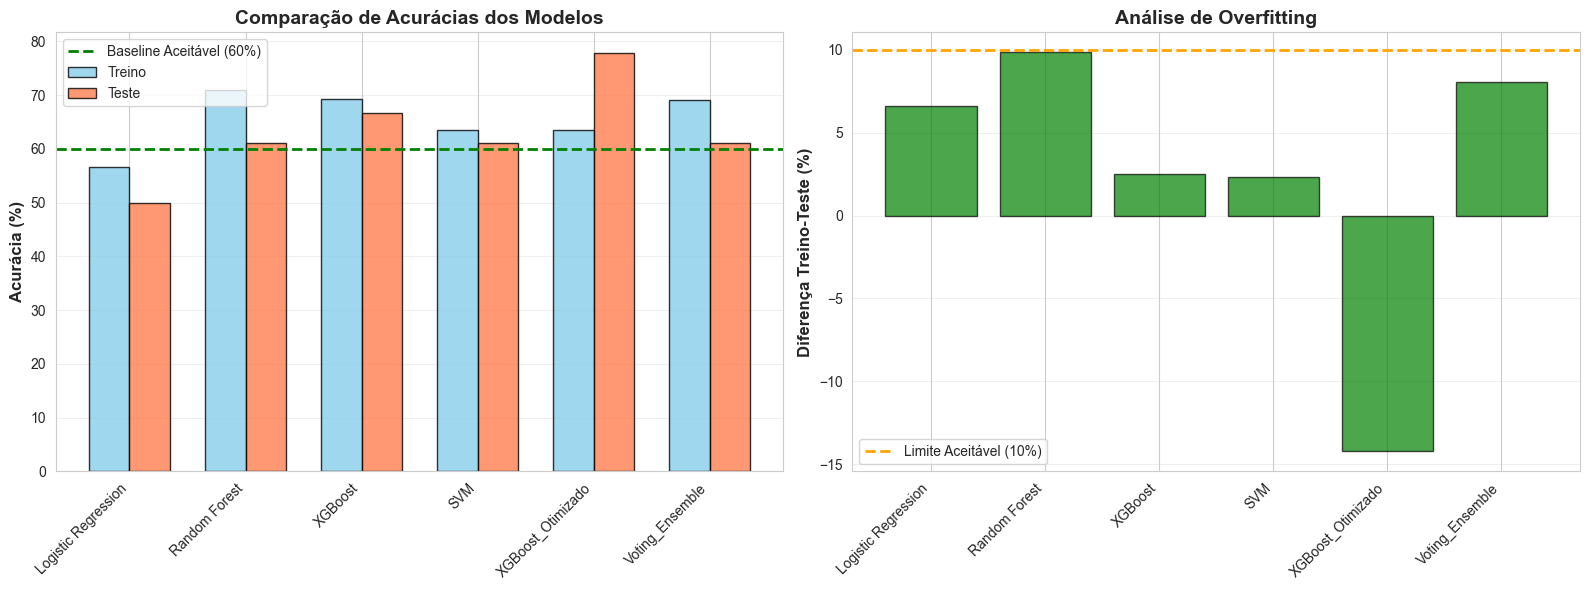

  ✓ Gráfico salvo: matriz_confusao.png


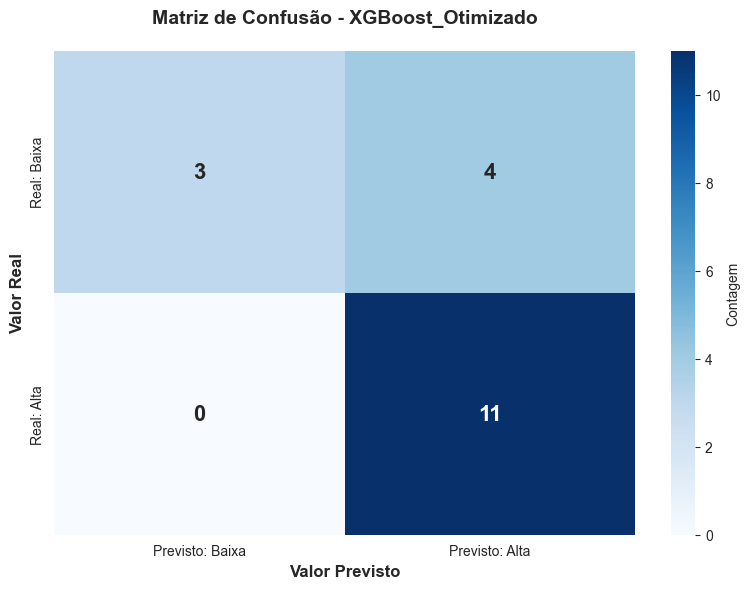

  ✓ Gráfico salvo: predicoes_tempo.png


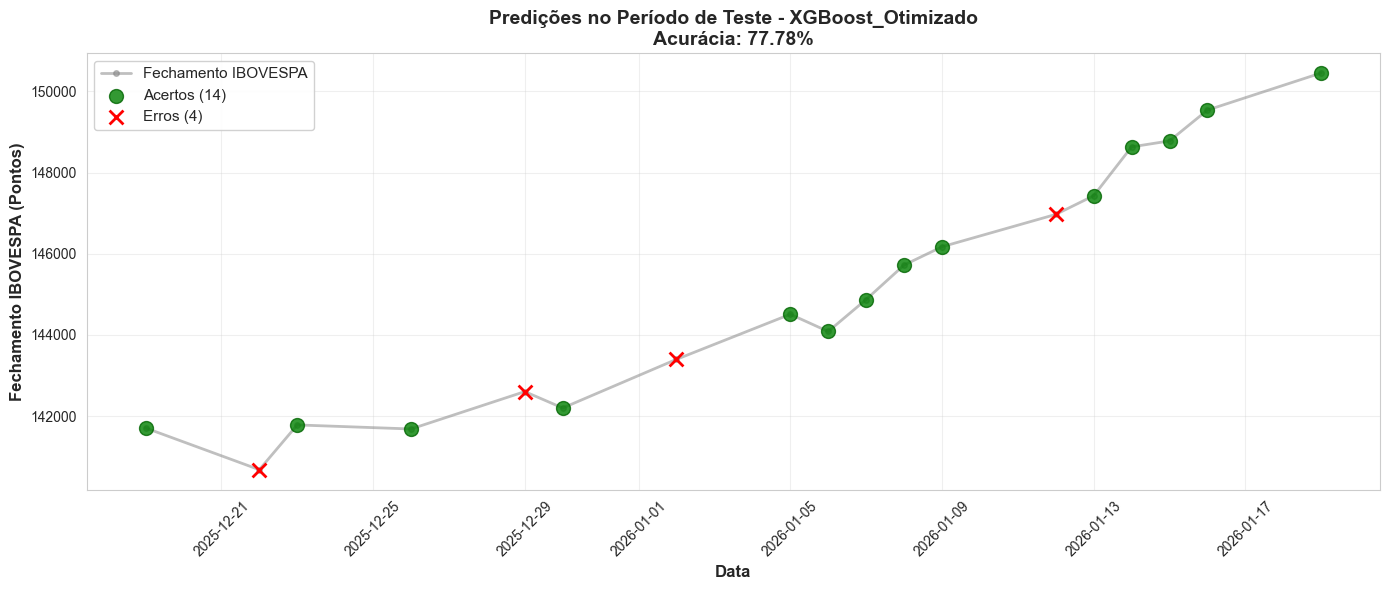

In [86]:
# Bloco 19 - Ajuste de variáveis para os gráficos finais
# Objetivo: Garantir que as variáveis usadas nos gráficos estejam corretas.

# 1. Define qual conjunto de dados usar (Selecionado ou Completo)

if 'X_test_scaled_sel' in locals():

    X_teste_correto = X_test_scaled_sel

else:

    X_teste_correto = X_test_scaled

# 1. Define os dados de teste corretos para o gráfico de tempo
datas_grafico = datas_test
y_real_grafico = y_test

# --- INÍCIO DAS VISUALIZAÇÕES ---

# 2. Figura 1: Comparação de Modelos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models = list(resultados.keys())
train_accs = [r['acc_train']*100 for r in resultados.values()]
test_accs = [r['acc_test']*100 for r in resultados.values()]

x_pos = np.arange(len(models))
width = 0.35

axes[0].bar(x_pos - width/2, train_accs, width, label='Treino', alpha=0.8, color='skyblue', edgecolor='black')
axes[0].bar(x_pos + width/2, test_accs, width, label='Teste', alpha=0.8, color='coral', edgecolor='black')
axes[0].axhline(y=60, color='green', linestyle='--', linewidth=2, label='Baseline Aceitável (60%)')
axes[0].set_ylabel('Acurácia (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Comparação de Acurácias dos Modelos', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

overfitting = [(r['acc_train'] - r['acc_test'])*100 for r in resultados.values()]
colors = ['green' if o < 10 else 'orange' if o < 15 else 'red' for o in overfitting]

axes[1].bar(models, overfitting, color=colors, alpha=0.7, edgecolor='black')
axes[1].axhline(y=10, color='orange', linestyle='--', linewidth=2, label='Limite Aceitável (10%)')
axes[1].set_ylabel('Diferença Treino-Teste (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Análise de Overfitting', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('comparacao_modelos.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico salvo: comparacao_modelos.png")
plt.show()

# 3. Figura 2: Matriz de Confusão (Já calculada no bloco anterior 'cm')
# Recalcula cm para garantir que é do melhor modelo usando o X correto
y_pred_final = melhor_modelo.predict(X_test_scaled_sel)
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar_kws={'label': 'Contagem'},
            xticklabels=['Previsto: Baixa', 'Previsto: Alta'],
            yticklabels=['Real: Baixa', 'Real: Alta'],
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title(f'Matriz de Confusão - {melhor_nome}', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
plt.xlabel('Valor Previsto', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('matriz_confusao.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico salvo: matriz_confusao.png")
plt.show()

# 4. Figura 4: Predições no Tempo (Corrigido para alinhar datas e previsões)
# OBS: Usa os índices de teste para buscar o preço real no DF original
# Nota: Precisamos alinhar pelo índice pois removemos colunas do X
precos_teste = ibov.loc[y_test.index, 'Fechamento']

resultados_teste = pd.DataFrame({
    'Data': datas_grafico.values,
    'Fechamento': precos_teste.values,
    'Real': y_real_grafico.values,
    'Previsto': y_pred_final,
    'Correto': (y_real_grafico.values == y_pred_final).astype(int)
})

fig, ax = plt.subplots(figsize=(14, 6))

# 5. Plota o preço
ax.plot(resultados_teste['Data'], resultados_teste['Fechamento'],
        'o-', linewidth=2, markersize=4, label='Fechamento IBOVESPA', color='gray', alpha=0.5)

# 6. Filtra acertos e erros
acertos = resultados_teste[resultados_teste['Correto'] == 1]
erros = resultados_teste[resultados_teste['Correto'] == 0]

# 7. Plota pontos de acerto (Verde) e erro (Vermelho) sobre o preço
ax.scatter(acertos['Data'], acertos['Fechamento'],
           s=100, c='green', marker='o', label=f'Acertos ({len(acertos)})', zorder=5, alpha=0.8, edgecolors='darkgreen')
ax.scatter(erros['Data'], erros['Fechamento'],
           s=100, c='red', marker='x', label=f'Erros ({len(erros)})', zorder=5, linewidths=2)

ax.set_xlabel('Data', fontsize=12, fontweight='bold')
ax.set_ylabel('Fechamento IBOVESPA (Pontos)', fontsize=12, fontweight='bold')
ax.set_title(f'Predições no Período de Teste - {melhor_nome}\nAcurácia: {melhor_acc:.2f}%',
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('predicoes_tempo.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico salvo: predicoes_tempo.png")
plt.show()


### Conclusão e Resumo final - Bloco 21 ao 23

In [87]:
# Bloco 21 - Resumo final para apresentação
# Objetivo: Gerar um resumo textual dos resultados alcançados.

comparison = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'CV Média': [r.get('cv_mean', 0)*100 for r in resultados.values()],
    'Treino (%)': [r['acc_train']*100 for r in resultados.values()],
    'Teste (%)': [r['acc_test']*100 for r in resultados.values()],
    'Overfitting (%)': [(r['acc_train'] - r['acc_test'])*100 for r in resultados.values()]
})

print(f"\n>> Dados:")
print(f"  Período: {df['Data'].min().date()} até {df['Data'].max().date()}")
print(f"  Total de dias analisados: {len(df)}")
print(f"  Features selecionadas (Final) : {len(selected_features)}")

print(f"\n>> Melhor Modelo:") ### Ajustar
print(f"  Nome: {melhor_nome}")
print(f"  Acurácia Treino: {comparison[comparison['Modelo']==melhor_nome]['Treino (%)'].values[0]:.2f}%")
print(f"  Acurácia Teste: {melhor_acc:.2f}%")
print(f"  Overfitting: {comparison[comparison['Modelo']==melhor_nome]['Overfitting (%)'].values[0]:.2f}%")

status_meta = "OK! ATINGIDA" if melhor_acc >= 70 else "NOK! NÃO ATINGIDA"
print(f"  Status da Meta (70%): {status_meta}")


print(f"\n>> Técnicas Aplicadas:")
print("   ✓ Feature Engineering (Técnico e Macro)")
print("   ✓ Normalização de Dados (StandardScaler)")
print("   ✓ Validação Cruzada Temporal (TimeSeriesSplit)")
print("   ✓ Grid Search (Otimização de Hiperparâmetros)")
print("   ✓ Ensemble Learning (Voting Classifier)")
print("   ✓ Combate ao Overfitting")


>> Dados:
  Período: 2016-03-17 até 2026-01-20
  Total de dias analisados: 2446
  Features selecionadas (Final) : 33

>> Melhor Modelo:
  Nome: XGBoost_Otimizado
  Acurácia Treino: 63.55%
  Acurácia Teste: 77.78%
  Overfitting: -14.23%
  Status da Meta (70%): OK! ATINGIDA

>> Técnicas Aplicadas:
   ✓ Feature Engineering (Técnico e Macro)
   ✓ Normalização de Dados (StandardScaler)
   ✓ Validação Cruzada Temporal (TimeSeriesSplit)
   ✓ Grid Search (Otimização de Hiperparâmetros)
   ✓ Ensemble Learning (Voting Classifier)
   ✓ Combate ao Overfitting


In [88]:
# Bloco 22 - Salvamento do modelo (Deploy final)
# Objetivo: Salvar o modelo treinado, o scaler e a lista de features.

import joblib
import os

print(">> Salvando os arquivos do modelo...")

# 1. Cria a pasta se não existir
if not os.path.exists('modelo_treinado'):
    os.makedirs('modelo_treinado')

# 2. Salva o Modelo (O Cérebro)
# Usa o nome do melhor modelo para facilitar identificação
nome_arquivo_modelo = f'modelo_treinado/modelo_ibovespa_{melhor_nome.replace(" ", "_")}.pkl'
joblib.dump(melhor_modelo, nome_arquivo_modelo)
print(f"   ✓ Modelo salvo: {nome_arquivo_modelo}")

# 3. Salva o Scaler (A Régua)
# Essencial para novos dados terem a mesma escala do treino
joblib.dump(scaler, 'modelo_treinado/scaler_ibovespa.pkl')
print(f"   ✓ Scaler salvo: modelo_treinado/scaler_ibovespa.pkl")

# 4. Salva a Lista de Features (O Mapa)
# Garante que, no futuro, a gente saiba a ordem exata das colunas
feats_final = selected_features if 'selected_features' in locals() else features
joblib.dump(feats_final, 'modelo_treinado/features.pkl')
print(f"   ✓ Lista de Features salva: modelo_treinado/features.pkl")

print("\nOK! PROJETO CONCLUÍDO! Todos os artefatos foram salvos.")
print("   Você pode baixar a pasta 'modelo_treinado' para usar no seu TCC.")

>> Salvando os arquivos do modelo...
   ✓ Modelo salvo: modelo_treinado/modelo_ibovespa_XGBoost_Otimizado.pkl
   ✓ Scaler salvo: modelo_treinado/scaler_ibovespa.pkl
   ✓ Lista de Features salva: modelo_treinado/features.pkl

OK! PROJETO CONCLUÍDO! Todos os artefatos foram salvos.
   Você pode baixar a pasta 'modelo_treinado' para usar no seu TCC.


In [89]:
# Bloco 23 - Simulador final --- #Prever o último dia da data (se for manual, prever o pós do último)
# Objetivo: Pegar o último dia disponível nos dados e ver qual seria a ordem do robô.

print("Calculando previsão do dia seguinte...")

# 1. Carregar os artefatos (Simulando um ambiente de produção)
# OBS: Mesmo que as variáveis já existam, é boa prática carregar para garantir que o save funcionou.
try:
    modelo_carregado = joblib.load(f'modelo_treinado/modelo_ibovespa_{melhor_nome.replace(" ", "_")}.pkl')
    scaler_carregado = joblib.load('modelo_treinado/scaler_ibovespa.pkl')
    features_carregadas = joblib.load('modelo_treinado/features.pkl')
    print("✓ Modelo e artefatos carregados com sucesso.")
except:
    print("NOK! Erro ao carregar arquivos salvos. Usando variáveis da memória...")
    modelo_carregado = melhor_modelo
    scaler_carregado = scaler
    features_carregadas = selected_features if 'selected_features' in locals() else features

# 2. Selecionar o Último Dia do Dataset
ultimo_dia = df.iloc[[-1]].copy()
data_atual = ultimo_dia['Data'].values[0]

print(f"\n>> Data de Referência: {pd.to_datetime(data_atual).date()}")

# 3. Preparar os dados (Exatamente como no treino)
# Seleciona apenas as features usadas no treinamento
X_hoje_raw = ultimo_dia[features_carregadas]

# Aplica a escala (StandardScaler)
X_hoje_scaled = scaler_carregado.transform(X_hoje_raw)

# 4. Fazer a Previsão
previsao = modelo_carregado.predict(X_hoje_scaled)[0]
probabilidade = modelo_carregado.predict_proba(X_hoje_scaled)[0]

# 5. Exibir Resultado
print("\n" + "="*40)
print(f"   PREVISÃO DO ROBÔ ({melhor_nome})")
print("="*40)

if previsao == 1:
    print(f">> TENDÊNCIA: ALTA (Comprar)")
    print(f"   Confiança: {probabilidade[1]*100:.2f}%")
else:
    print(f">> TENDÊNCIA: BAIXA (Vender/Aguardar)")
    print(f"   Confiança: {probabilidade[0]*100:.2f}%")

print("="*40)
print("\nNota: Esta previsão é baseada no fechamento do dia anterior.")

Calculando previsão do dia seguinte...
✓ Modelo e artefatos carregados com sucesso.

>> Data de Referência: 2026-01-20

   PREVISÃO DO ROBÔ (XGBoost_Otimizado)
>> TENDÊNCIA: BAIXA (Vender/Aguardar)
   Confiança: 53.48%

Nota: Esta previsão é baseada no fechamento do dia anterior.
